## Week 15: Lecture 1

We have been studying classifcation with logistic regression. We want to explore two components of classification. 

First, we want to classify into three or more categories. We learned about the One-vs-Rest approach to classifying into multiple categories. However, we need to fit a model for each category. Instead of breaking the classification problem into multiple problems, we will try to extend logistic regression to treat three or more categories. 

Second we want to explore approaches with wiggly decision boundaries. Remember that we used polynomial feature transformation to determine a curved decision boundary. However, we might want to have a broken curve that winds around different regions of points. We will learn the nearest neighbors approach to classification that allows for multiple decision boundaries. 

In [32]:
# importing some packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.optimize import minimize

from helper_functions import *

# changing some settings

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)

%matplotlib inline
plt.rcParams['figure.figsize'] = (9,7)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Multiple Categories

We have a dataset with two features and one response variable.


In [2]:
three_categories = pd.read_csv("three_categories.csv")
three_categories

,Feature 1,Feature 2,Categories
0,0.840220,1.148022,0
1,-1.154748,-1.204117,1
2,0.678636,0.724180,0
3,0.450783,-1.427097,2
4,1.492116,1.480952,0
...,...,...,...
745,0.852327,0.904248,0
746,-1.375152,-0.826757,1
747,0.267989,-1.278334,2
748,-0.886288,-0.302932,1


The response variable consists of three categories. Remember that the categories are qualitative data. So we could use color to label the categories in place of numbers.

In [3]:
three_categories["Categories Colors"] = three_categories["Categories"].replace({0:"purple", 1:"green", 2:"yellow"})
three_categories

,Feature 1,Feature 2,Categories,Categories Colors
0,0.840220,1.148022,0,purple
1,-1.154748,-1.204117,1,green
2,0.678636,0.724180,0,purple
3,0.450783,-1.427097,2,yellow
4,1.492116,1.480952,0,purple
...,...,...,...,...
745,0.852327,0.904248,0,purple
746,-1.375152,-0.826757,1,green
747,0.267989,-1.278334,2,yellow
748,-0.886288,-0.302932,1,green


With the colors we can generate a scatter-plot. 

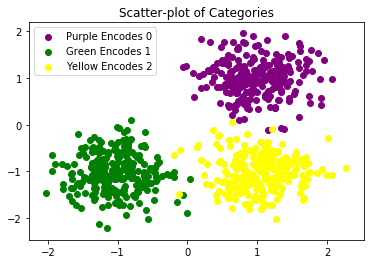

In [4]:
purple = three_categories[three_categories["Categories Colors"] == "purple"]
yellow = three_categories[three_categories["Categories Colors"] == "yellow"]
green = three_categories[three_categories["Categories Colors"] == "green"]

plt.scatter(purple["Feature 1"], purple["Feature 2"], c = "purple", label ="Purple Encodes 0")
plt.scatter(green["Feature 1"], green["Feature 2"], c = "green", label ="Green Encodes 1")
plt.scatter(yellow["Feature 1"], yellow["Feature 2"], c = "yellow", label ="Yellow Encodes 2")

plt.legend()
plt.title("Scatter-plot of Categories");

We have three categories labeled 0,1,2. We can use the One-vs-Rest approach. Here we split the classification problem into three classification problems

- category 0 versus category 1 or 2
- category 1 versus category 0 or 2
- category 2 versus category 0 or 1

We need to fit three logistic regression models.

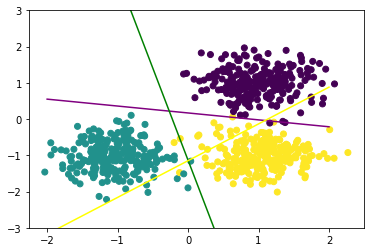

In [5]:
plot_three_categories(three_categories)

If we have a point, then we can use each model to determine a number. Remember that these number represent probabilities. We take the category corresponding to the highest probability. For example, if the probabilities we 

- Category 0 : 0.45 
- Category 1 : 0.72
- Category 2 : 0.32

then we would classify the point into category 1. 

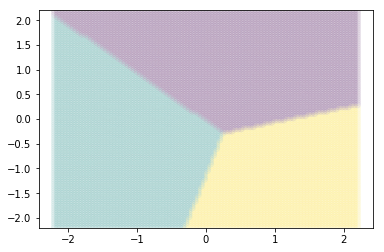

In [6]:
predictions = plot_three_categories_predictions(three_categories, False)

We manage to classify all points into the categories 0,1,2. Note that we have three regions corresponding to the three categories. The regions correspond to the three categories in the data. 


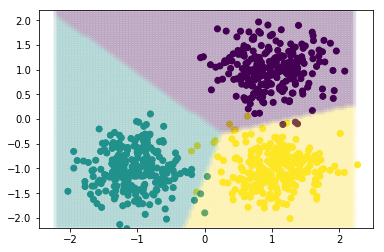

In [7]:
predictions = plot_three_categories_predictions(three_categories)

We obtain 98% accuracy.

In [8]:
observations =  three_categories["Categories"].values
accuracy(observations, predictions)

0.98

We can generate a confusion matrix to show the different types of errors.

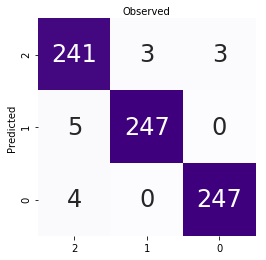

In [9]:
category_values = [2,1,0]
observed, predicted = np.meshgrid(category_values, category_values)

values = []
for ob, pred in zip(observed.flatten(), predicted.flatten()):
    equalities = (observations == ob) & (predictions == pred)
    values.append(sum(equalities))
    
plot_confusion(np.array(values).reshape(3,3))

We have equal number of points in each category. However, if we had a category with few points compared to the other categories, then we could have an imbalance. Since few points would not contribute much to the average logistic loss, we can classify most points into the other categories without penalty. The One-vs-Rest approach might forget about the categories with fewer points. 

In [10]:
print("Number of purple points: {}".format(len(three_categories[three_categories["Categories Colors"] == "purple"])))
print("Number of yellow points: {}".format(len(three_categories[three_categories["Categories Colors"] == "yellow"])))
print("Number of green points: {}".format(len(three_categories[three_categories["Categories Colors"] == "green"])))

Number of purple points: 250
Number of yellow points: 250
Number of green points: 250


We can try a different approach that extends logistic regression to three categories. For two categories we had the model 

$$
P(Y = 1 \; | \; X) = \sigma(w_0 + w_1 \cdot X_1 + w_2 \cdot X_2)
$$

Here $X_1$ and $X_2$ are the explanatory variables, $Y$ is the response variable and 
$$\sigma(t) = \frac{1}{1 + e^{-t}}$$ 

is the sigmoid function. So the probability that the response variable equals 1 conditional on the explanatory variable is a transformation under the sigmoid function of a sum of products between slopes and features. Remember from the complement rule that 

$$
P(Y = 0 \; | \; X) = 1 - P(Y = 1 \; | \; X) 
$$

So we have

$$
\begin{align}
\operatorname{log} \displaystyle \frac{P(Y = 1 \; | \; X)}{P(Y=0 \; | \; X)} & = \operatorname{log} \displaystyle \frac{P(Y = 1 \; | \; X)}{1 - P(Y=1 \; | \; X)} \\ & =  \log e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2} \\ & = w_0 + w_1 \cdot X_1 + w_2 \cdot X_2 
\end{align}
$$

Here we use the fact $\log e^t = t$ for any number $t$. We can extend from two categories to three categories

$$
\begin{align}
\operatorname{log} \displaystyle \frac{P(Y = 1 \; | \; X)}{P(Y=0 \; | \; X)} = w_0 + w_1 \cdot X_1 + w_2 \cdot X_2 \\
\operatorname{log} \displaystyle \frac{P(Y = 2 \; | \; X)}{P(Y=0 \; | \; X)} = v_0 + v_1 \cdot X_1 + v_2 \cdot X_2
\end{align}
$$

Instead of parameters $w_0,w_1,w_2$, we have parameters
$$w_0,w_1,w_2,v_0,v_1,v_2$$

We can rewrite the expression 
$$
\begin{align}
P(Y = 1 \; | \; X) = P(Y=0 \; | \; X) \cdot e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2} \\
P(Y = 2 \; | \; X) = P(Y=0 \; | \; X) \cdot e^{v_0 + v_1 \cdot X_1 + v_2 \cdot X_2}
\end{align}
$$

Since $1 = P(Y = 0 \; | \; X) + P(Y = 1 \; | \; X) + P(Y = 2 \; | \; X)$ we have 

$$
1 = P(Y = 0 \; | \; X) \left(1 + e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2} + e^{v_0 + v_1 \cdot X_1 + v_2 \cdot X_2} \right)
$$

So we learn that 

$$
\begin{align}
P(Y = 0 \; | \; X) = \displaystyle\frac{1}{1 + e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2} + e^{v_0 + v_1 \cdot X_1 + v_2 \cdot X_2}} \\
P(Y = 1 \; | \; X) = \displaystyle\frac{e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2}}{1 + e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2} + e^{v_0 + v_1 \cdot X_1 + v_2 \cdot X_2}} \\
P(Y = 2 \; | \; X) = \displaystyle\frac{e^{v_0 + v_1 \cdot X_1 + v_2 \cdot X_2}}{1 + e^{w_0 + w_1 \cdot X_1 + w_2 \cdot X_2} + e^{v_0 + v_1 \cdot X_1 + v_2 \cdot X_2}}
\end{align}
$$

Remember that we need to classify into three categories. So we should take the category corresponding to the highest probability. Denote the three probabilities $\hat{y_0}, \hat{y_1}, \hat{y_2}$. For two categories, we had the logistic loss 

$$
-y \log \hat{y} - (1 - y) \log(1 - \hat{y} )
$$

Here $0 \leq \hat{y} \leq 1$ was the predicted probability of category 1 and $y=0$ or $y=1$ was the observed category. We can modify the logistic loss to 

$$
\begin{cases}
- \log \hat{y_0} & \text{if } y = 0 \\
- \log \hat{y_1} & \text{if } y = 1 \\
- \log \hat{y_2} & \text{if } y = 2 
\end{cases}
$$

Taking the average logistic loss across the training set, we can determine the missing pieces of the model $w_0,w_1,w_2,v_0,v_1,v_2$.

In [11]:
feature1 = three_categories["Feature 1"]
feature2 = three_categories["Feature 2"]
observed = three_categories["Categories"]
initial_guess = np.zeros(6)

slopes = minimize(compute_average_logistic_loss, 
                  x0 = initial_guess,
                  args= (feature1, feature2, observed)).x

In [15]:
def compute_logistic_predictions(feature1, feature2, slopes):
    params = make_params(slopes)

    predictions_probabilities = []
    for feat1, feat2 in zip(feature1, feature2):
        probs = soft_max(feat1, feat2, params)
        predictions_probabilities.append(list(probs.values()))
    
    temp = pd.DataFrame(data = predictions_probabilities)
    temp["max"] = temp.apply(np.argmax, axis = 1)

    return temp["max"].values

predictions = compute_logistic_predictions(three_categories["Feature 1"].values, three_categories["Feature 2"].values, slopes)

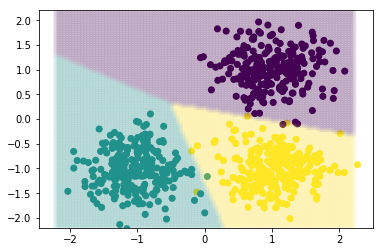

In [23]:
number_points = 100

xvalues = np.linspace(-2.2,2.2,number_points)
yvalues = np.linspace(-2.2,2.2,number_points)
x, y = np.meshgrid(xvalues, yvalues)

predictions_background = compute_logistic_predictions(x.flatten(), y.flatten(),slopes)

plt.scatter(three_categories["Feature 1"], three_categories["Feature 2"], c = three_categories["Categories"]);

plt.scatter(x.flatten(), 
            y.flatten(), 
            c = predictions_background,
            alpha = 0.05)

plt.ylim([-2.2,2.2]);  

We obtain 99% accuracy.

In [16]:
observations =  three_categories["Categories"].values
accuracy(observations, predictions)

0.9946666666666667

We can generate a confusion matrix to show the different types of errors.

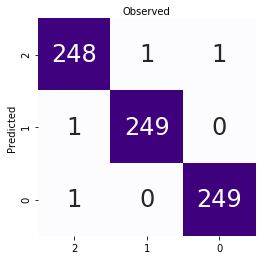

In [17]:
category_values = [2,1,0]
observed, predicted = np.meshgrid(category_values, category_values)

values = []
for ob, pred in zip(observed.flatten(), predicted.flatten()):
    equalities = (observations == ob) & (predictions == pred)
    values.append(sum(equalities))
    
plot_confusion(np.array(values).reshape(3,3))

### Nearest Neighbors

Suppose we want to use regression for qualitative variables. 

In [24]:
patients = pd.read_csv("breast-cancer.csv")
patients

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,...,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,...,3,1,1,0
1,1002945,5,4,4,...,3,2,1,0
2,1015425,3,1,1,...,3,1,1,0
3,1016277,6,8,8,...,3,7,1,0
4,1017023,4,1,1,...,3,1,1,0
...,...,...,...,...,...,...,...,...,...
678,776715,3,1,1,...,1,1,1,0
679,841769,2,1,1,...,1,1,1,0
680,888820,5,10,10,...,8,10,2,1
681,897471,4,8,6,...,10,6,1,1


Here we have a dataset with information about patient screenings for breast cancer. The response variable is `Class`. While the categories are encoded with 0 and 1, we should think of 0 and 1 as labels for benign and malignant. 

In [25]:
patients = patients[["Single Epithelial Cell Size", "Class"]].copy()
patients

,Single Epithelial Cell Size,Class
0,2,0
1,7,0
2,2,0
3,3,0
4,2,0
...,...,...
678,3,0
679,2,0
680,7,1
681,3,1


Instead of 0 and 1, we can encode the categories with colors.

In [26]:
colors = []
for number in patients["Class"]:
    if number == 1:
        colors.append("red")
    else:
        colors.append("blue")
    
patients["Class Color"] = colors
patients

,Single Epithelial Cell Size,Class,Class Color
0,2,0,blue
1,7,0,blue
2,2,0,blue
3,3,0,blue
4,2,0,blue
...,...,...,...
678,3,0,blue
679,2,0,blue
680,7,1,red
681,3,1,red


Now we can generate a scatter-plot to show the distribution of the reponse variable.

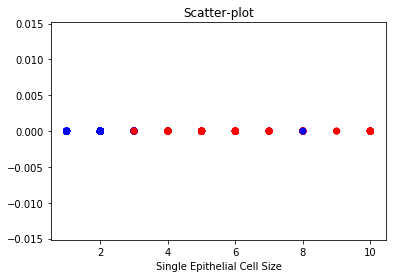

In [27]:
number_of_records = len(patients)

plt.scatter(patients["Single Epithelial Cell Size"], 
            np.zeros(number_of_records) ,
            c = patients["Class Color"])

plt.xlabel("Single Epithelial Cell Size")
plt.title("Scatter-plot");

We can generate a scatter-plot of the explanatory variable `Single Epithelial Cell`. Here yellow encodes the value 1 and 

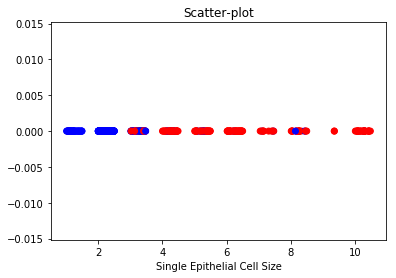

In [28]:
number_of_records = len(patients)
plt.scatter(patients["Single Epithelial Cell Size"] + 0.5 * np.random.rand(number_of_records), 
            np.zeros(len(patients)), 
            c = patients["Class Color"])

plt.xlabel("Single Epithelial Cell Size")
plt.title("Scatter-plot");

Since we have over-plotting we can jitter the points along the horizontal component. 

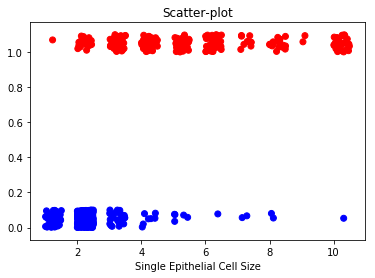

In [29]:
number_of_records = len(patients)
plt.scatter(patients["Single Epithelial Cell Size"] + 0.5 * np.random.rand(number_of_records), 
            patients["Class"] + 0.1 * np.random.rand(number_of_records), 
            c = patients["Class Color"])

plt.xlabel("Single Epithelial Cell Size")
plt.title("Scatter-plot");

Since we have trouble visualizing the data on one axis, we should use two axes. 

In [37]:
table = patients 
explanatory_variable = "Single Epithelial Cell Size"
response_variable = "Class"

linear_model = LinearRegression()
linear_model.fit(table[[explanatory_variable]], table[response_variable])

observed_slope = linear_model.coef_[0]
observed_intercept = linear_model.intercept_

We could try to use least squares regression to fit a line to the data. 

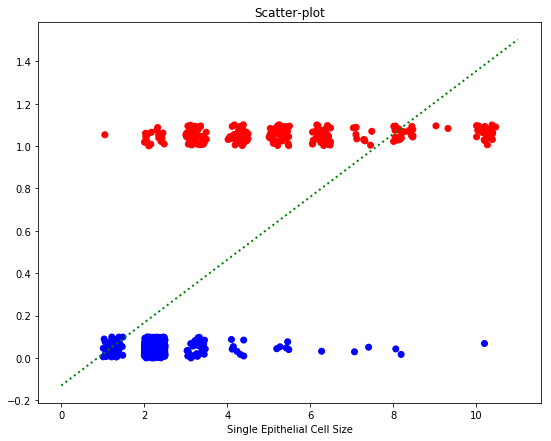

In [40]:
number_of_records = len(patients)
plt.scatter(patients["Single Epithelial Cell Size"] + 0.5 * np.random.rand(number_of_records), 
            patients["Class"] + 0.1 * np.random.rand(number_of_records), 
            c = patients["Class Color"])

xvalue = np.linspace(0,11,50)
plt.plot(xvalue, observed_intercept + observed_slope * xvalue, "g:", lw = 2)

plt.xlabel("Single Epithelial Cell Size")
plt.title("Scatter-plot");

However, we seem to miss the pattern in the data. The line cannot bend between 0 and 1.

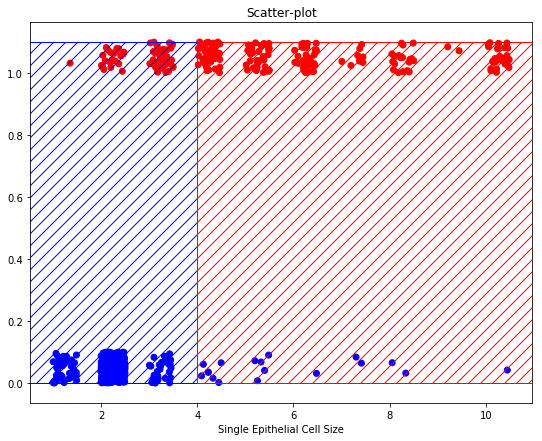

In [41]:
number_of_records = len(patients)
plt.scatter(patients["Single Epithelial Cell Size"] + 0.5 * np.random.rand(number_of_records), 
            patients["Class"] + 0.1 * np.random.rand(number_of_records), 
            c = patients["Class Color"])

add_patch(plt.gca(), [[0,0],[4,0],[4,1.1],[0,1.1]], color = "blue")
add_patch(plt.gca(), [[4,0],[11,0],[11,1.1],[4,1.1]], color = "red")


plt.xlabel("Single Epithelial Cell Size")
plt.title("Scatter-plot");

Really we want to divide the points into two regions separated by a threshold. If we take the threshold to be 4, then we would classify point like 8 as red and points like 2 as blue.

In [42]:
patients_with_neighbors = patients.copy()
patients_with_neighbors

,Single Epithelial Cell Size,Class,Class Color
0,2,0,blue
1,7,0,blue
2,2,0,blue
3,3,0,blue
4,2,0,blue
...,...,...,...
678,3,0,blue
679,2,0,blue
680,7,1,red
681,3,1,red


In [44]:
point_to_classify = 7.5

patients_with_neighbors["Distance"] = abs(patients_with_neighbors["Single Epithelial Cell Size"] - point_to_classify)
patients_with_neighbors

,Single Epithelial Cell Size,Class,Class Color,Distance
0,2,0,blue,5.5
1,7,0,blue,0.5
2,2,0,blue,5.5
3,3,0,blue,4.5
4,2,0,blue,5.5
...,...,...,...,...
678,3,0,blue,4.5
679,2,0,blue,5.5
680,7,1,red,0.5
681,3,1,red,4.5


In [45]:
patients_with_neighbors = patients_with_neighbors.sort_values("Distance", ascending=True)
patients_with_neighbors

,Single Epithelial Cell Size,Class,Class Color,Distance
40,8,1,red,0.5
171,8,1,red,0.5
65,8,1,red,0.5
276,8,1,red,0.5
207,7,1,red,0.5
...,...,...,...,...
36,1,0,blue,6.5
146,1,0,blue,6.5
455,1,0,blue,6.5
379,1,0,blue,6.5


In [46]:
number_of_neighbors = 11   # 101

smallest_distances = patients_with_neighbors[:number_of_neighbors]
smallest_distances

,Single Epithelial Cell Size,Class,Class Color,Distance
40,8,1,red,0.5
171,8,1,red,0.5
65,8,1,red,0.5
276,8,1,red,0.5
207,7,1,red,0.5
...,...,...,...,...
555,8,1,red,0.5
620,7,1,red,0.5
200,7,1,red,0.5
397,8,1,red,0.5


In [47]:
number_in_class_1 = np.sum(smallest_distances["Class"])
number_in_class_0 = number_of_neighbors - number_in_class_1

print("Fraction of Neighbors in Class 1 : {:0.1f}".format(number_in_class_1 / number_of_neighbors))
print("Fraction of Neighbors in Class 0 : {:0.1f}".format(number_in_class_0 / number_of_neighbors))

Fraction of Neighbors in Class 1 : 1.0
Fraction of Neighbors in Class 0 : 0.0


#### Classifications 

In [48]:
def proportion_among_neighbors(original_data, point_to_classify, number_of_neighbors):
    data = original_data.copy()
    
    data["Distance"] = abs(data["Single Epithelial Cell Size"] - point_to_classify)
    
    data = data.sort_values("Distance", ascending=True)

    smallest_distances = data[:number_of_neighbors]

    number_in_class_1 = np.sum(smallest_distances["Class"])
    number_in_class_0 = number_of_neighbors - number_in_class_1

    return number_in_class_0 / number_of_neighbors, number_in_class_1 / number_of_neighbors

In [49]:
original_data = patients
point_to_classify = 7.5
number_of_neighbors = 101

fraction_blue, fraction_red = proportion_among_neighbors(original_data, point_to_classify, number_of_neighbors)     
        
print("Fraction of Neighbors in Class 1 : {}".format(fraction_red))
print("Fraction of Neighbors in Class 0 : {}".format(fraction_blue))

Fraction of Neighbors in Class 1 : 0.9108910891089109
Fraction of Neighbors in Class 0 : 0.0891089108910891


In [50]:
def classify_point(original_data, point_to_classify, number_of_neighbors):
    fraction_blue, fraction_red = proportion_among_neighbors(original_data, point_to_classify, number_of_neighbors)     
    
    if fraction_blue >= fraction_red:
        category = 0
    else:
        category = 1
        
    return category

In [51]:
original_data = patients
point_to_classify = 7.5
number_of_neighbors = 101

predicted_category = classify_point(original_data, point_to_classify, number_of_neighbors)

print("Predicted Category {} for Singe Epithelial Cell Size {}".format(predicted_category, point_to_classify))

Predicted Category 1 for Singe Epithelial Cell Size 7.5
